In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input,
    LeakyReLU, MaxPooling2D, SeparableConv2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [2]:
# Укажем путь к дериктории
PATH = 'internship_data'
MALE = os.path.join(PATH,'male')
FEMALE = os.path.join(PATH,'female')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##   Посмотрим, сколько изображений и каких размеров в датасете, для выбора размера входного слоя в модели.

In [3]:
img_sizes = dict()

i = 0

for picture in tqdm(os.listdir(FEMALE)):
    if '.jpg' in picture:
        im = Image.open(os.path.join(FEMALE,picture))
        
        if im.size in img_sizes.keys():
            img_sizes[im.size] +=1
        else:
            img_sizes[im.size] = 1
for picture in tqdm(os.listdir(MALE)):
    if '.jpg' in picture:
        im = Image.open(os.path.join(MALE,picture))
        
        if im.size in img_sizes.keys():
            img_sizes[im.size] +=1
        else:
            img_sizes[im.size] = 1
img_sizes_sorted = sorted(img_sizes.items(), key=lambda x: x[1], reverse=True)

100%|██████████| 50001/50001 [00:46<00:00, 1083.38it/s]


## Посмотрим на 10 самых популярных:

In [4]:
schet = 0 
for i in img_sizes_sorted:
    if schet != 10:
        print('\nРазмер изображения: ', i[0], 
              '\nКоличество изображений с таким размером:',
              i[1])
        schet+=1
    else:
        break


Размер изображения:  (70, 94) 
Количество изображений с таким размером: 56

Размер изображения:  (98, 127) 
Количество изображений с таким размером: 53

Размер изображения:  (77, 100) 
Количество изображений с таким размером: 52

Размер изображения:  (101, 133) 
Количество изображений с таким размером: 52

Размер изображения:  (84, 112) 
Количество изображений с таким размером: 52

Размер изображения:  (75, 97) 
Количество изображений с таким размером: 51

Размер изображения:  (95, 126) 
Количество изображений с таким размером: 50

Размер изображения:  (86, 115) 
Количество изображений с таким размером: 50

Размер изображения:  (93, 125) 
Количество изображений с таким размером: 49

Размер изображения:  (87, 115) 
Количество изображений с таким размером: 49


### Больше всего изображений с размером 70х94, но тем не менее их достаточно мало, чтобы принять решение конкретно размеров входных данных, следовательно нужно будет  сжимать или растягивать изображения до оптимального размера.

## Укажем размер для входных изображений, batch_size, и название модели.

In [3]:
batch_size = 128
IMG_HEIGHT = 96
IMG_WIDTH = 96
model_name = 'Gender_2'

## Создадим генератор входных изображений, который будет подгружать фотографии в модель, во время обучения. Также разделим датасет в пропорции 30/70 на валидацию и обучение.

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                        validation_split = 0.30, rotation_range=40,
                        width_shift_range=0.2, height_shift_range=0.2, 
                        shear_range=0.2, zoom_range=0.2, 
                        horizontal_flip=True, fill_mode='nearest')
                        # каждый раз изображения будут искажаться

In [5]:
# Генератор для тренировочной выборки
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory=PATH,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           subset = 'training')
print()
# Генератор для валидационной выборки 
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory = PATH,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='binary',
                                                         subset = 'validation')

Found 70002 images belonging to 2 classes.

Found 30000 images belonging to 2 classes.


## Создадим модель свёрточной нейронной сети

In [6]:
input_tensor = Input(shape = (IMG_HEIGHT, IMG_WIDTH, 3))
#============================================================================================================
layer1 = layers.Conv2D(filters = 16, kernel_size = (3, 3), 
                        padding = 'same', activation = 'relu')(input_tensor)
layer1 = layers.BatchNormalization()(layer1)
layer1 = layers.MaxPooling2D()(layer1)

#============================================================================================================

layer2 = layers.Conv2D(filters = 32, kernel_size = (3, 3), 
                        padding = 'same', activation = 'relu')(layer1)
layer2 = layers.BatchNormalization()(layer2)
layer3 = layers.MaxPooling2D()(layer2)

#============================================================================================================

layer4 = layers.Conv2D(filters = 64, kernel_size = (3, 3), 
                        padding = 'same', activation = 'relu')(layer3)
layer4 = layers.BatchNormalization()(layer4)
layer4 = layers.MaxPooling2D()(layer4)

#============================================================================================================

layer5 = layers.Conv2D(filters = 128, kernel_size = (3, 3), 
                        padding = 'same', activation = 'relu')(layer4)
layer5 = layers.BatchNormalization()(layer5)
layer5 = layers.MaxPooling2D()(layer5)

#============================================================================================================

layer6 = layers.Flatten()(layer5)

#============================================================================================================

layer7 = layers.Dense(256, activation = 'relu')(layer6)

#============================================================================================================

layer8 = layers.Dense(1, activation = 'sigmoid')(layer7)

In [7]:
model = Model(input_tensor, layer8)

## Пропишем обратные вызовы для сохранения промежуточных моделей и прекращения обучения при обучении.

In [8]:
callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2,verbose = 1),
                                # Обучение будет остановлено если функция потерь на валидации не будет
                                # падать в течение 3- х эпох.
                   
                   tf.keras.callbacks.ModelCheckpoint( 
                                filepath =  model_name +'.h5', 
                                monitor='val_accuracy',save_best_only=True, mode = 'max', verbose = 1),
                                # Будет сохраняться модель с наилучшей точностью на валидации  
                   
                   tf.keras.callbacks.ReduceLROnPlateau( 
                                monitor='val_loss', factor = 0.1, 
                                patience = 1, verbose = 1),
                                # Скорость обучения будет уменьшаться в 10 раз, если от эпохи к эпохе
                                # функция потерь на валидации не будет увличиваться в течение 2-х эпох
                  ]

In [9]:
# оптимизатор - Adam 
# функция потерь - кросс энтропия
# метрика - доля правильных ответов
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])

## Посмотрим на модель.

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0     

## Обучение модели.

In [11]:
hist = model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_data_gen.samples // batch_size,
    epochs = 15,
    validation_data = val_data_gen,
    validation_steps= val_data_gen.samples // batch_size,
    callbacks = callbacks_list)

Epoch 1/15
545/546 [============================>.] - ETA: 0s - loss: 0.3399 - accuracy: 0.8519
Epoch 00001: val_accuracy improved from -inf to 0.87804, saving model to Gender_2.h5
546/546 [==============================] - 283s 518ms/step - loss: 0.3397 - accuracy: 0.8519 - val_loss: 0.2881 - val_accuracy: 0.8780
Epoch 2/15
545/546 [============================>.] - ETA: 0s - loss: 0.1855 - accuracy: 0.9236
Epoch 00002: val_accuracy improved from 0.87804 to 0.91179, saving model to Gender_2.h5
546/546 [==============================] - 298s 546ms/step - loss: 0.1854 - accuracy: 0.9236 - val_loss: 0.2214 - val_accuracy: 0.9118
Epoch 3/15
545/546 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9375
Epoch 00003: val_accuracy improved from 0.91179 to 0.91787, saving model to Gender_2.h5
546/546 [==============================] - 286s 524ms/step - loss: 0.1538 - accuracy: 0.9375 - val_loss: 0.2018 - val_accuracy: 0.9179
Epoch 4/15
545/546 [==========================

In [11]:
# Метки для каждого класса
label_map = (train_data_gen.class_indices)
print(label_map)

{'female': 0, 'male': 1}


## Валидация модели на картинке из Интернета

Исходное изображение 
 



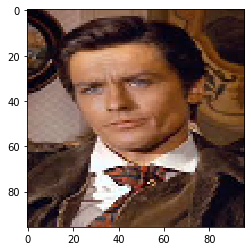

In [15]:
img_path = 'C:\\Users\\dmtry\\Desktop\\test\\Без Названия.jpg'
img = image.load_img(img_path, target_size=(96, 96)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255

plt.imshow(img_tensor.reshape(96,96,3)) 
print('Исходное изображение','\n','\n')

plt.show()

In [16]:
from Process import test_data
test_data('C:\\Users\\dmtry\\Desktop\\test')

{'Без названия.jpg': 'male'}